In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
weather= pd.read_csv('/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_BWF_AnalyzingFlightDelays/flights_weather2022.csv')
flights= pd.read_csv('/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_BWF_AnalyzingFlightDelays/flights2022.csv')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a 'route' column combining 'origin' and 'dest'
flights['route'] = flights['origin'] + '-' + flights['dest']

# Calculate average departure delays and cancellations by route
routes_delays_cancels = flights.groupby('route').agg(
    avg_dep_delay=('dep_delay', 'mean'),
    cancels=('dep_delay', lambda x: (x > 0).sum())  # Assuming a cancellation is when dep_delay > 0
).reset_index()


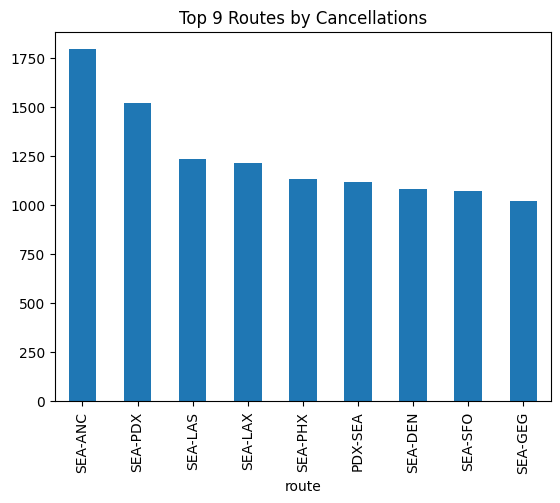

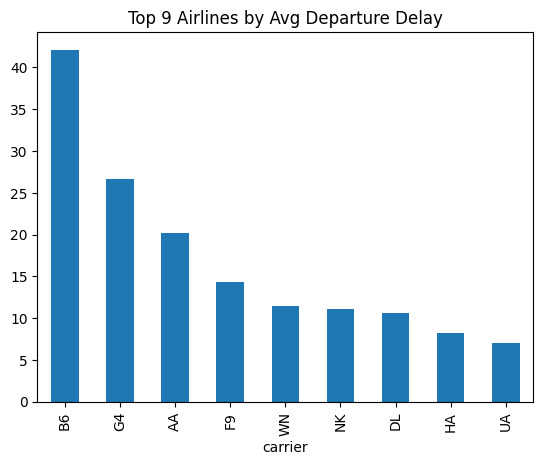

In [5]:

# Calculate average departure delays and cancellations by airline
airlines_delays_cancels = flights.groupby('carrier').agg(
    avg_dep_delay=('dep_delay', 'mean'),
    cancels=('dep_delay', lambda x: (x > 0).sum())  # Similar logic for cancellations
).reset_index()

# Plot the top 9 routes with the highest number of cancellations
top9_route_cancels = routes_delays_cancels.nlargest(9, 'cancels')
top9_route_cancels_bar = top9_route_cancels.plot.bar(
    x='route', y='cancels', legend=False, title='Top 9 Routes by Cancellations'
)
plt.show()

# Plot the top 9 airlines with the highest average departure delays
top9_airline_delays = airlines_delays_cancels.nlargest(9, 'avg_dep_delay')
top9_airline_delays_bar = top9_airline_delays.plot.bar(
    x='carrier', y='avg_dep_delay', legend=False, title='Top 9 Airlines by Avg Departure Delay'
)
plt.show()


In [6]:
# Install dask if you haven't already
!pip install dask


In [ ]:
import dask.dataframe as dd

# Convert pandas DataFrames to Dask DataFrames
flights_dd = dd.from_pandas(flights, npartitions=10)
weather_dd = dd.from_pandas(weather, npartitions=10)

# Perform the merge using Dask
merged_data_dd = dd.merge(
    flights_dd, weather_dd,
    left_on=['year', 'month', 'day', 'origin'],
    right_on=['year', 'month', 'day', 'origin'],
    how='left'
)

# Convert back to pandas DataFrame (or continue using Dask if feasible)
merged_data = merged_data_dd.compute()


In [ ]:
# Calculate average departure delays for SEA and PDX with and without high wind
high_wind_delays = merged_data[merged_data['wind_speed'] > 20].groupby('origin')['dep_delay'].mean()  # Assuming 'wind_speed' > 20 defines high wind
low_wind_delays = merged_data[merged_data['wind_speed'] <= 20].groupby('origin')['dep_delay'].mean()

# Determine wind impact for SEA and PDX
sea_wind_response = high_wind_delays.get('SEA', 0) > low_wind_delays.get('SEA', 0)
pdx_wind_response = high_wind_delays.get('PDX', 0) > low_wind_delays.get('PDX', 0)

# Set wind_response to True if wind increases delays for both SEA and PDX
wind_response = sea_wind_response and pdx_wind_response



In [ ]:
# Outputs
routes_delays_cancels, airlines_delays_cancels, wind_response